<a href="https://colab.research.google.com/github/microprediction/winning/blob/main/Ability_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install winning
!pip install pandas
!pip install scipy
!pip install nevergrad
from winning.skew_calibration import skew_dividend_implied_ability, skew_ability_implied_dividends
import numpy as np 
import pylab 
import scipy.stats as stats 
import pandas as pd
from winning.skew_calibration import skew_dividend_implied_ability, skew_ability_implied_dividends, state_price_implied_ability
import numpy as np 
import pylab 
from winning.lattice import center_density, skew_normal_density
from winning.lattice_conventions import ALT_UNIT, ALT_L, ALT_SCALE, ALT_A
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import norm
import math 



# Some empirical ability transforms - just for fun

In [13]:

def normalize(x):
  x_sum = np.sum(x)
  return [xi/x_sum for xi in x]

def standardize(x):
    xc = [xi-np.mean(x) for xi in x]
    xs = [xci/np.std(xc) for xci in xc ] 
    return xs 

def ability_transform(x,a,cull=1):
    sx = list(reversed(sorted(x)))
    nzx = [ x_ for x_ in sx if x_>0 ][cull:-cull]  # Chop highest and lowest
    z = normalize(nzx)
    zt = [ max(zi,0.00000000005) for zi in z] # Instability - need to look into this or increase lattice
    density = skew_normal_density(L=2*ALT_L, unit=ALT_UNIT, loc=0., scale=ALT_SCALE, a=a)
    ability = state_price_implied_ability(prices=zt, density=density)
    return standardize(ability) 

def proximity(x,a):
    sa = ability_transform(x,a)
    cdfs = [ stats.norm.cdf(sai) for sai in sa ]
    n = len(cdfs)
    std_cdfs = np.linspace(1/(n+1),1-1/(n+1),n)
    return np.mean([ abs(c1-c2) for c1,c2 in zip(sorted(cdfs),std_cdfs)])

def ability_fit(x):
    """
       Finds the skew best matching the distribution
    """
    def objective(a):
      return proximity(x,a)

    result = minimize(objective, x0=[0], bounds=[(-3,3)],options={'maxiter':100})
    best_a = result.x.tolist()[0] 

    return best_a
    
def ability_plot(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   f = stats.probplot(y, dist="norm", plot=pylab)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)
   pylab.show()
   return f
   

def manual_search(x):
   ajs = list(np.linspace(-4,4,50))
   prox = [proximity(x,aj) for aj in ajs ]
   plt.plot(ajs,prox)


# Market cap

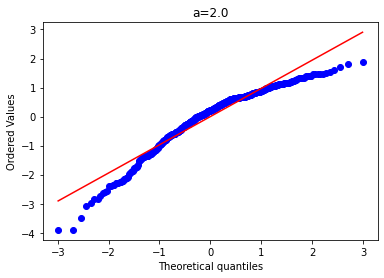

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasets/s-and-p-500-companies-financials/master/data/constituents-financials.csv')
ability_plot(df['Market Cap'].values,a=2.0)

# Snooker prizemoney

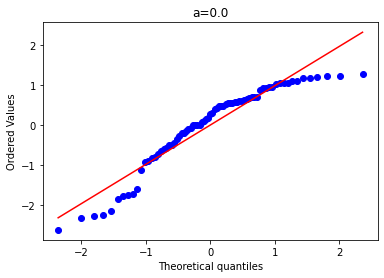

In [ ]:
snooker = pd.read_csv('https://raw.githubusercontent.com/rafaluk/snooker_prizes/master/snooker_data.csv',sep=';')
vals=snooker['Money_Prizes'].values
ability_plot(vals,a=0.)

# Power Law

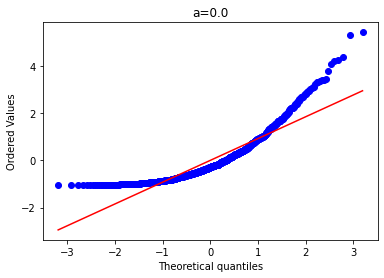

In [ ]:
r = stats.powerlaw.rvs(a=1.66, size=1000)
ability_plot(r,0.0)

# More fakery

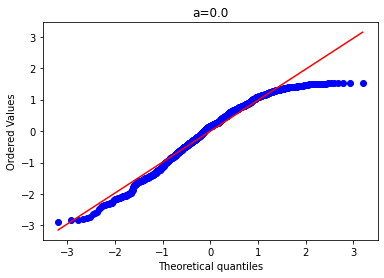

In [ ]:
x = stats.expon.rvs(0.5,size=1000)
ability_plot(x,0.0)

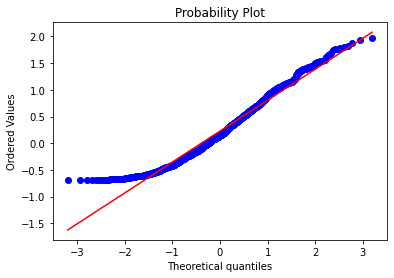

In [ ]:
logx = [ math.log(0.0000001+c) for c in x]
f = stats.probplot(logx, dist="norm", plot=pylab)

# Athletic prizemoney

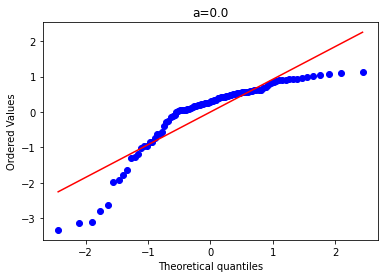

In [ ]:
athletes = pd.read_csv('https://raw.githubusercontent.com/ali-ce/datasets/master/Most-paid-athletes/Athletes.csv')
ability_plot(athletes['Total Pay'].replace('[\$,]', '', regex=True).astype(float),a=0.0)

# Global covid cases

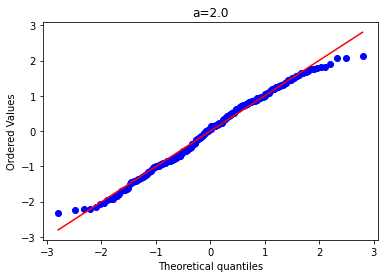

In [ ]:
covid = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
vals = covid[covid.columns[-1]].values
ability_plot(vals,a=2.0)

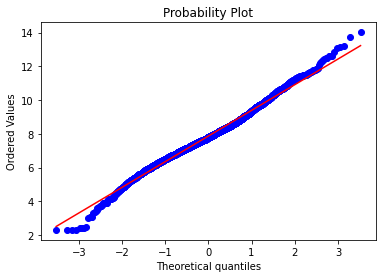

In [ ]:
tcases = [ math.log(10+c) for c in scases]
g = stats.probplot(tcases, dist="norm", plot=pylab)

# U.S. Covid by county

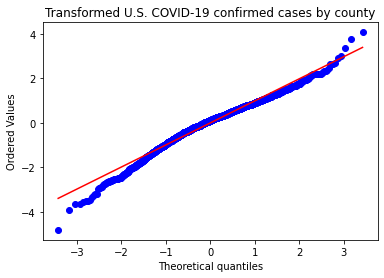

((array([-3.42043786, -3.17130311, -3.03322659, ...,  3.03322659,
          3.17130311,  3.42043786]),
  array([-4.80499264, -3.90938035, -3.6515304 , ...,  3.34053585,
          3.76429886,  4.06943268])),
 (0.9906891350231439, -1.0160425342890781e-16, 0.9893246556688093))

In [14]:
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv')
ccases = [ c for c in sorted(counties['confirmed_cases'].values) if c>0 ]
ability_plot(ccases,a=0.0,title='Transformed U.S. COVID-19 confirmed cases by county')


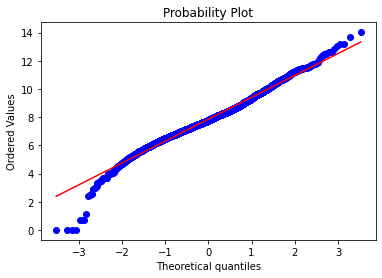

In [ ]:
tcases = [ math.log(1+c) for c in scases]
g =stats.probplot(tcases, dist="norm", plot=pylab)

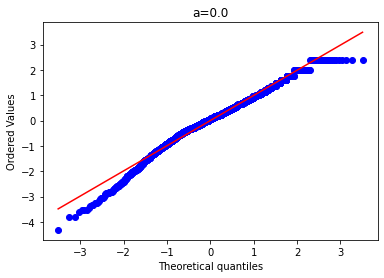

In [ ]:
sdeaths = sorted(counties['deaths'].values)
dths = [ d for d in sdeaths if d>0]
ability_plot(dths,a=0.0)

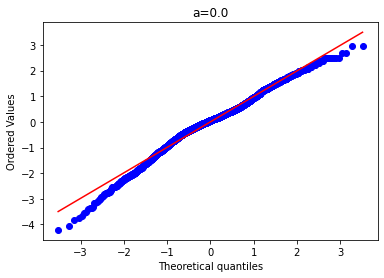

In [ ]:
county_density = pd.read_csv('https://raw.githubusercontent.com/camillol/cs424p3/master/data/Population-Density%20By%20County.csv')
sdensity = sorted(county_density['Density per square mile of land area'])
ability_plot(sdensity,a=0.0)


# City sizes

In [ ]:
city_sizes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv')

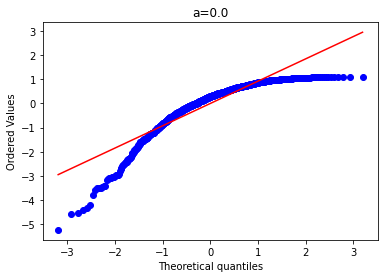

In [ ]:
ability_plot(city_sizes['Population'])
# Better fit by power law?

# Different COVID data from paper 
.... that says its a power law

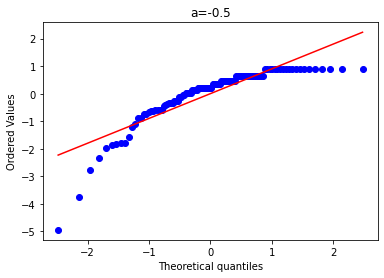

In [ ]:
covid_from_power_law = pd.read_csv('https://raw.githubusercontent.com/berndblasius/Covid19/master/data/time_series_19-covid-Deaths.csv')
sv = [ v for v in covid_from_power_law[covid_from_power_law.columns[-1]].values if v>1]
ability_plot(sv,-0.5)

# GDP / capita

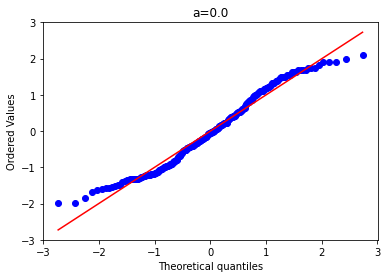

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/worldFactbook/GDPPerCapita.csv')
vals = df['GDP Per Capita']
ability_plot(vals,a=0.0)

# Laptops per country

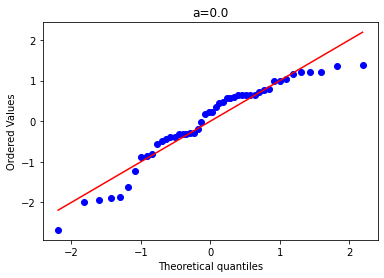

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/olpc/laptopsPerCountry.csv')
vals = df['count']
ability_plot(vals,a=0.0)

In [ ]:
# Linchings by state

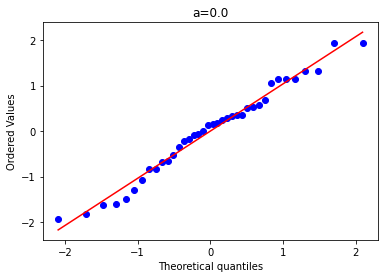

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/tuskegeeInstitute/lynchings-1882-1968-by-state-and-race.csv')
ability_plot(df['Total'])

# Migrants

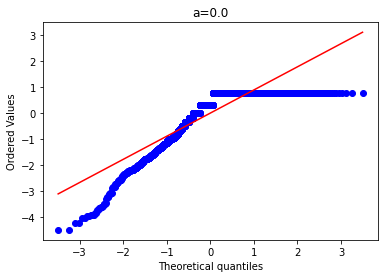

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/migrants/events.csv')
ability_plot(df['dead_and_missing'])

# Weed prices

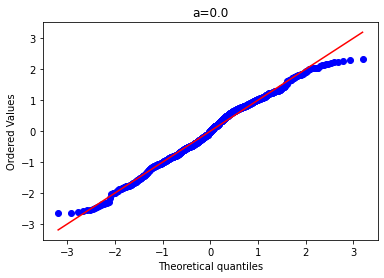

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/amitkaps/weed/Weed_Price.csv')
ability_plot(df['HighQN'][:1000],a=0.0)

# State populations

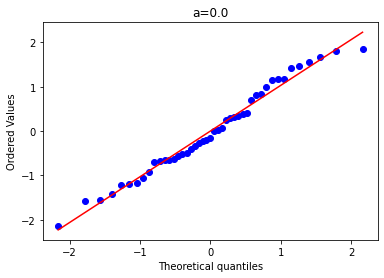

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/amitkaps/weed/Population_State.csv')
ability_plot(df['value'],a=0.0)

# Syrian violations

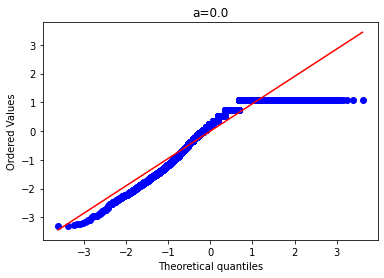

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/SyriaViolationsDocumentationCenter/dataAggregated.csv')
ability_plot(df['count'],a=0.0)

# Mortality causes

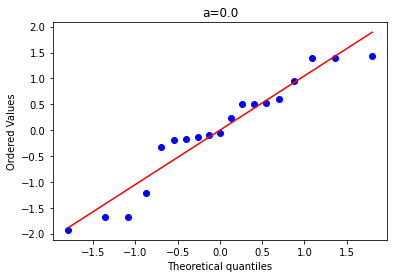

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/cdc_mortality_mortality_underyling_cause_by_years_simplified.csv')
ability_plot(df['1998'],a=0.0)

# Infant mortality

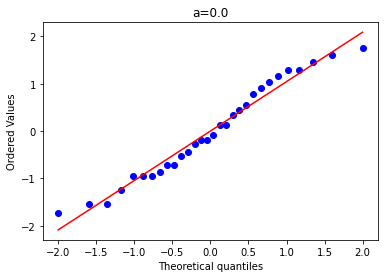

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/data.gov.in_infantMortalityRate_Infant_Mortality_Rate_1.csv')
ability_plot(df['2011'],a=0.0)

# Petals

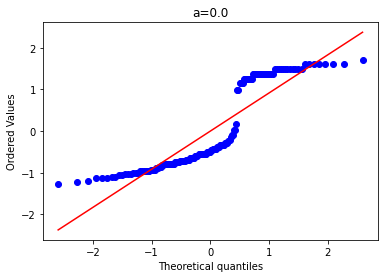

In [ ]:
df= pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/iris_iris.csv')
ability_plot(df['Petal Length'],a=0.0)

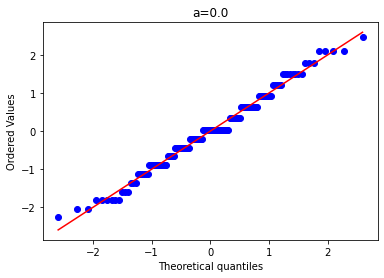

In [ ]:
ability_plot(df['Sepal Width'],a=0.0)

# More city populations

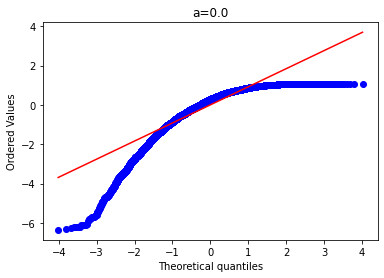

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/geonames_cities15000.csv')
ability_plot(df['population'],a=0.0)

# browser market share

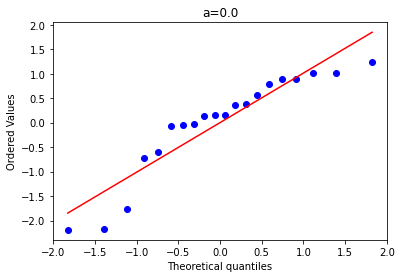

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/statCounter_currentBrowserMarketShares.csv')
ability_plot(df['marketShare'],a=0.0)

# Earthquake magnitudes

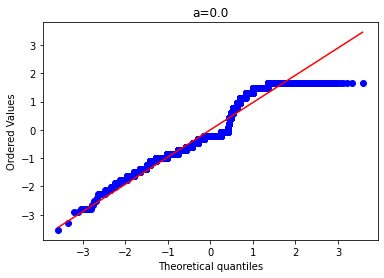

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/usgs_centennial_earthquakes.csv')
ability_plot(df['magnitude'][:4000],a=0.0)

#Prices

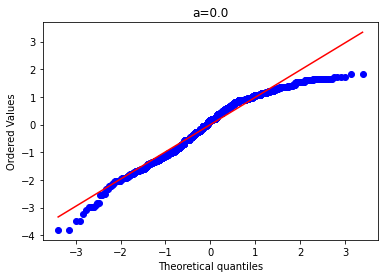

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/superstoreSales_superstoreSales.csv')
ability_plot(df['Unit Price'][:2000],a=0.)

# Christians by country

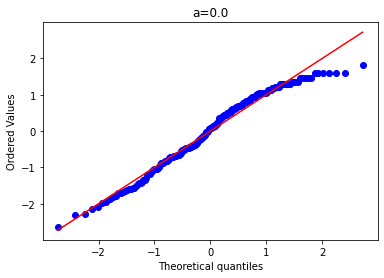

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/pew/religion/religionByCountry.csv')
ability_plot([float(v) for v in df['Christian'] if not '<' in v],a=0.0)

# Startups

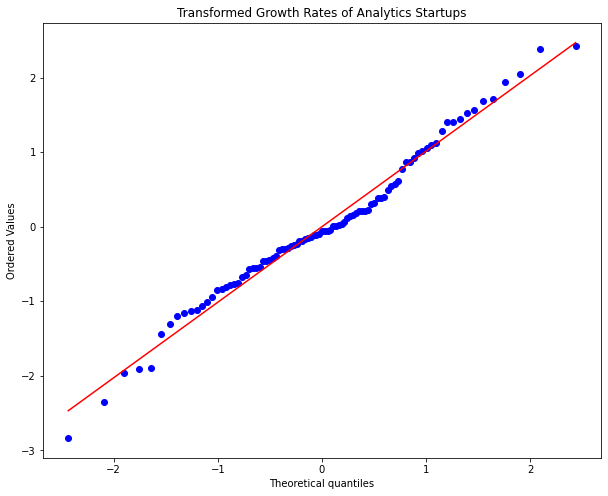

100

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/mattermark/2015-top-100-analytics-startups.csv')
plt.figure(figsize=(10,8))
ability_plot(df['Growth Score'],a=0.,title='Transformed Growth Rates of Analytics Startups')
len(df)

# Big data revenue

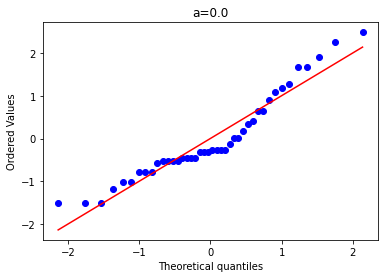

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/wikibon/revenueBigData2012.csv')
ability_plot(df['% Big Data Software Revenue'],a=0.0)

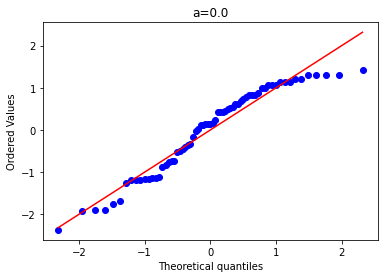

In [ ]:
ability_plot(df['Big Data Revenue'],a=0.0)

# War deaths

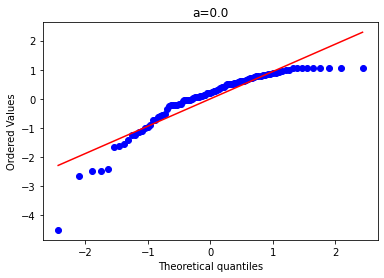

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/correlatesofwar/wars.csv')
ability_plot(df['batDeath'],a=0.0)

# Flu

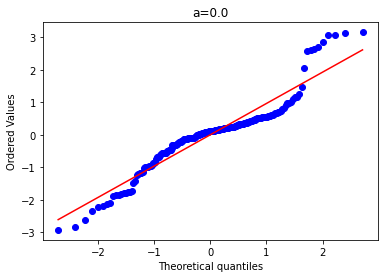

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/usda/avian_influenza/avian_flu_cleaned.csv')
ability_plot(df['Size'],a=0.0)

# Cars

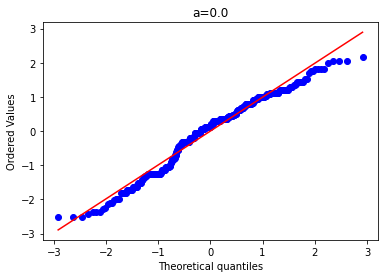

In [ ]:
df= pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/uci_ml/auto-mpg/auto-mpg.csv')
ability_plot(df['horsepower'],a=0.0)

# Abalone

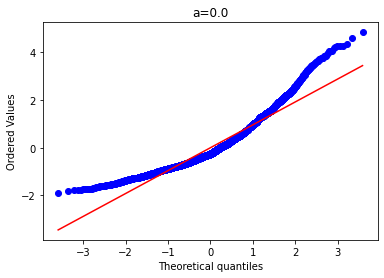

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/uci_ml/abalone/abalone.csv')
ability_plot(df['whole_weight'],a=0.0)

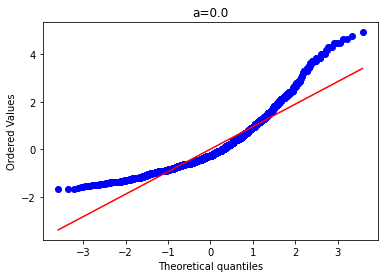

In [ ]:
ability_plot(df['diameter'],a=0.0)

# Synomyns 


In [ ]:
!pip install PyDictionary
!pip install wordfreq

In [ ]:
from PyDictionary import PyDictionary
from wordfreq import word_frequency
dictionary = PyDictionary()

def synonym_plot(wd='mother',a=0.0):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  ability_plot(freqs,a=a,cull=0)

def synonym_logplot(wd='mother'):
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  

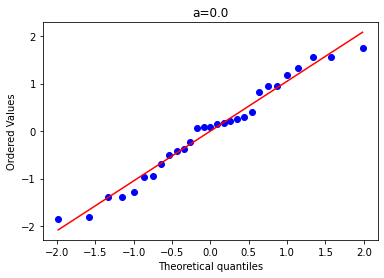

In [ ]:
synonym_plot('beautiful')

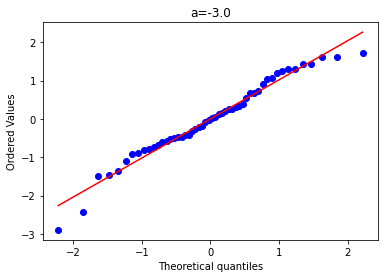

In [ ]:
synonym_plot('bright',a=-3.0)

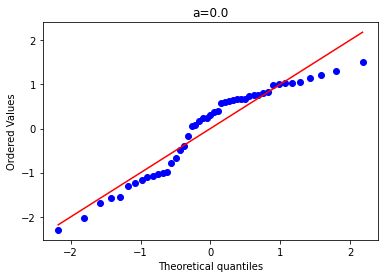

In [ ]:
synonym_plot('bad',a=0.0)

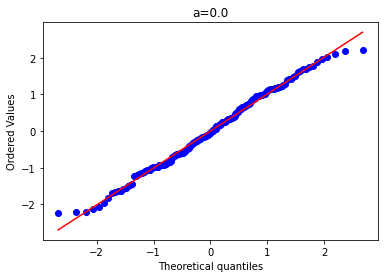

In [ ]:
synonym_plot('move',a=0.0)

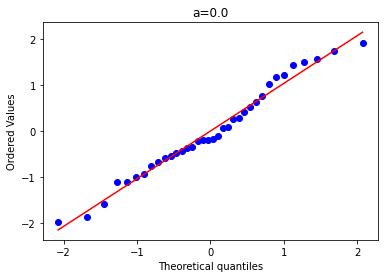

In [ ]:
synonym_plot('say',a=0.0)

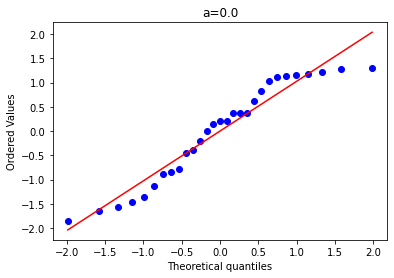

In [ ]:
synonym_plot('look',a=0.0)

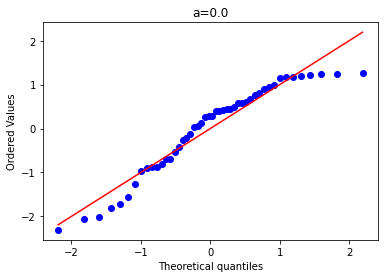

In [ ]:
synonym_plot('little',a=0.0)

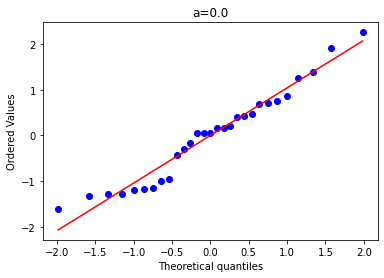

In [ ]:
synonym_plot('fear',a=0.0)

In [ ]:
# Surname frequencies

In [ ]:
def category_plot(category='cities',sub='united_states'):
  df = pd.read_csv('https://raw.githubusercontent.com/imsky/wordlists/master/names/CATEGORY/SUB.txt'.replace('CATEGORY',category).replace('SUB',sub))
  freqs = [ word_frequency(w,'en') for w in df[df.columns[0]].values ]
  ability_plot(freqs,cull=0)


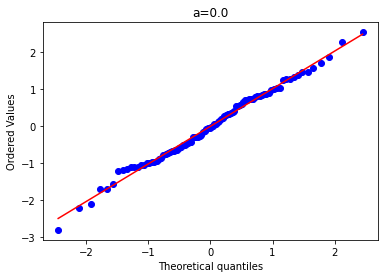

In [ ]:
category_plot('cities','united_states')

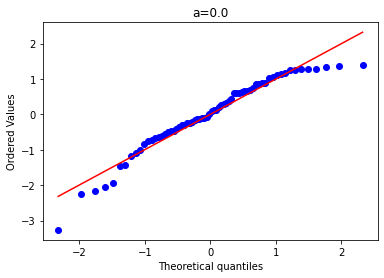

In [ ]:
category_plot('cities','france')

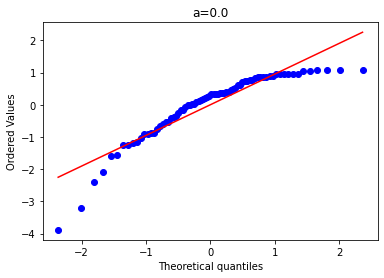

In [ ]:
category_plot('cities','netherlands')

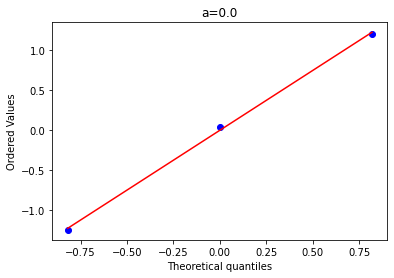

In [ ]:
category_plot('cities','canada')

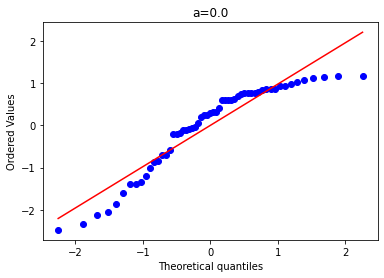

In [ ]:
category_plot('cities','switzerland')

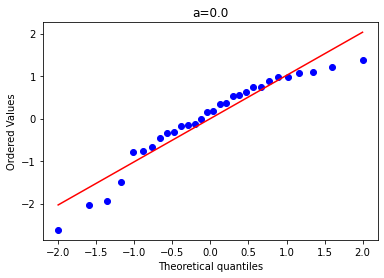

In [ ]:
category_plot('codenames','intel')

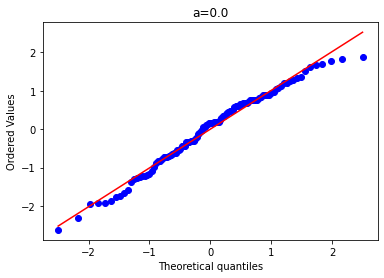

In [ ]:
category_plot('codenames','apple')

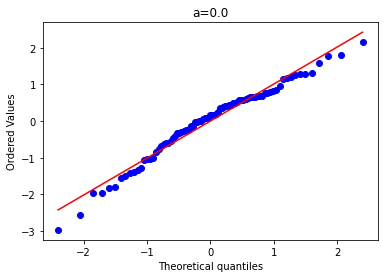

In [ ]:
category_plot('codenames','microsoft')

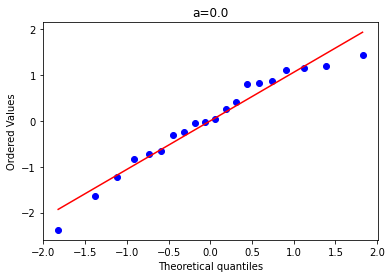

In [ ]:
category_plot('companies','unicorns')

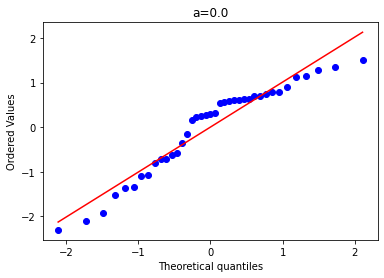

In [ ]:
category_plot('people','computing')

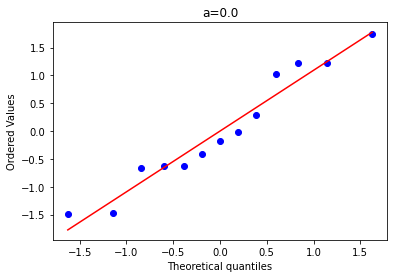

In [ ]:
category_plot('people','butlers')

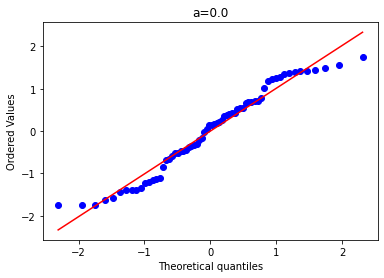

In [ ]:
category_plot('streets','newyork')

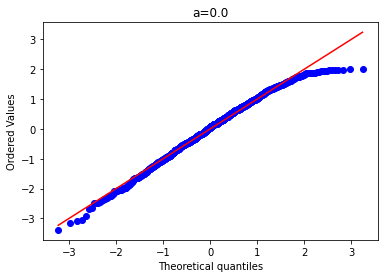

In [ ]:
category_plot('streets','chicago')

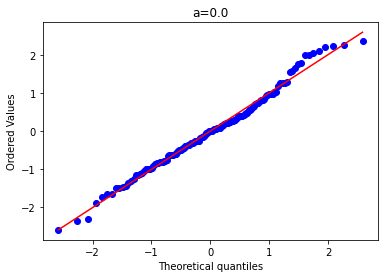

In [ ]:
category_plot('surnames','irish')

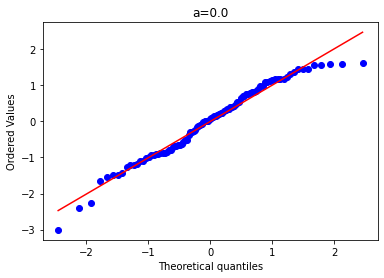

In [ ]:
category_plot('surnames','italian')

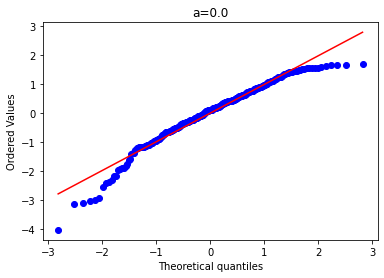

In [ ]:
category_plot('surnames','german')

# Trump votes

In [ ]:
!pip install benfordslaw

In [3]:
from benfordslaw import benfordslaw
bl = benfordslaw(alpha=0.05)
df = bl.import_example(data='USA')
X = df['votes'].loc[df['candidate']=='Donald Trump'].values
ability_plot(X,a=0.0)

ModuleNotFoundError: ignored

In [4]:
df

NameError: ignored

@misc{erdogant2020benfordslaw,
  title={benfordslaw},
  author={Erdogan Taskesen},
  year={2019},
  howpublished={\url{https://github.com/erdogant/benfordslaw}},
}

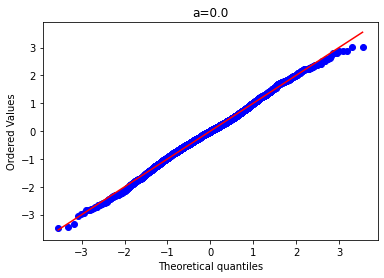

(0.0, 20000.0)

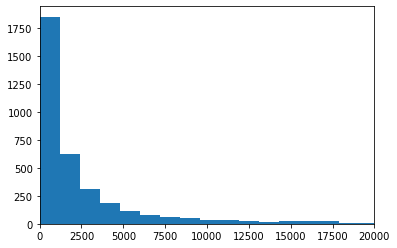

In [ ]:
f=plt.hist(X,bins=150)
plt.xlim([0,20000])

# Tweets

# References etc



https://statweb.stanford.edu/~owen/courses/306a/ZipfByHera.pdf



